In [1]:
LETTER_IMAGES_FOLDER = "extracted_letter_images"

In [2]:
import cv2
import imutils
def resize_image_to_fit(image, width, height):
    (h, w) = image.shape[:2]
    if w > h:
        image = imutils.resize(image, width=width)
    else:
        image = imutils.resize(image, height=height)
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE) ##nambahin border pd gambar
    image = cv2.resize(image, (width, height))
    return image

In [3]:
import numpy as np
import os
from imutils import paths
data = []
labels = []

for image_file in imutils.paths.list_images(LETTER_IMAGES_FOLDER):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = resize_image_to_fit(image, 20, 20)
    image = np.expand_dims(image, axis=2) #nambahin axis, di axis ke dua (3 urutan)
    label = image_file.split(os.path.sep)[-2]
    data.append(image)
    labels.append(label) #ngisi list label dgn nama file

In [4]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [5]:
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

In [6]:
#merubah multi class menjadi binary label
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
num_classes = 32
model = Sequential()
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               625500    
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [8]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

Train on 29058 samples, validate on 9686 samples
Epoch 1/10
29058/29058 [==============================] - 17s 584us/step - loss: 0.2440 - accuracy: 0.9403 - val_loss: 0.0178 - val_accuracy: 0.9958
Epoch 2/10
29058/29058 [==============================] - 17s 599us/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.0101 - val_accuracy: 0.9975
Epoch 3/10
29058/29058 [==============================] - 17s 570us/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0123 - val_accuracy: 0.9969
Epoch 4/10
29058/29058 [==============================] - 18s 620us/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0066 - val_accuracy: 0.9982
Epoch 5/10
29058/29058 [==============================] - 20s 684us/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0501 - val_accuracy: 0.9882
Epoch 6/10
29058/29058 [==============================] - 19s 664us/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0137 - val_accuracy: 0.9968
Epoch 7/10
29058/29058 [==============================] -

In [9]:
from keras.models import save_model
import pickle
model.save("CAPTCHA_NN.model")
with open("labels", "wb") as f:
    pickle.dump(lb, f)

Prediction

In [10]:
import pickle
from keras.models import load_model

with open("labels", "rb") as f:
    lb = pickle.load(f)
model = load_model("CAPTCHA_NN.model")

In [11]:
# CAPTCHA = "captcha_images/7ZHA.png"

In [12]:
def preprocessImage(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return gray, thresh

def contoursToRectangles(contours):
    letter_image_regions = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))
    return letter_image_regions

In [28]:
import os
directory = 'attacked_captcha_images_2'
benar = 0
salah = 0
for filename in os.listdir(directory):
    namafile_full = directory+'/'+filename
    image = cv2.imread(namafile_full)
    gray, preprocessedImage = preprocessImage(image)
    contours = cv2.findContours(preprocessedImage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0]
    letter_image_regions = contoursToRectangles(contours)
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    predictions = []
    for letter_bounding_box in letter_image_regions:
        x, y, w, h = letter_bounding_box
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        letter_image = resize_image_to_fit(letter_image, 20, 20)
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)
        prediction = model.predict(letter_image)
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

    predicted_captcha_text = "".join(predictions)
#     print("Prediksi Teks CAPTCHA: {}".format(predicted_captcha_text))
#     print("CAPTCHA text is: {}".format(filename.split("\\")[-1].split(".")[0]))
    if predicted_captcha_text == filename.split("\\")[-1].split(".")[0]:
        print("Prediksi Teks CAPTCHA: BENAR")
        benar = benar+1
    else:
        print("Prediksi Teks CAPTCHA: SALAH")
        salah = salah+1
    print(benar)
    print(salah)

Prediksi Teks CAPTCHA: SALAH
0
1
Prediksi Teks CAPTCHA: SALAH
0
2
Prediksi Teks CAPTCHA: SALAH
0
3
Prediksi Teks CAPTCHA: SALAH
0
4
Prediksi Teks CAPTCHA: SALAH
0
5
Prediksi Teks CAPTCHA: SALAH
0
6
Prediksi Teks CAPTCHA: SALAH
0
7
Prediksi Teks CAPTCHA: SALAH
0
8
Prediksi Teks CAPTCHA: SALAH
0
9
Prediksi Teks CAPTCHA: SALAH
0
10
Prediksi Teks CAPTCHA: SALAH
0
11
Prediksi Teks CAPTCHA: SALAH
0
12
Prediksi Teks CAPTCHA: SALAH
0
13
Prediksi Teks CAPTCHA: SALAH
0
14
Prediksi Teks CAPTCHA: SALAH
0
15
Prediksi Teks CAPTCHA: SALAH
0
16
Prediksi Teks CAPTCHA: SALAH
0
17
Prediksi Teks CAPTCHA: SALAH
0
18
Prediksi Teks CAPTCHA: SALAH
0
19
Prediksi Teks CAPTCHA: SALAH
0
20
Prediksi Teks CAPTCHA: SALAH
0
21
Prediksi Teks CAPTCHA: BENAR
1
21
Prediksi Teks CAPTCHA: SALAH
1
22
Prediksi Teks CAPTCHA: SALAH
1
23
Prediksi Teks CAPTCHA: SALAH
1
24
Prediksi Teks CAPTCHA: SALAH
1
25
Prediksi Teks CAPTCHA: BENAR
2
25
Prediksi Teks CAPTCHA: BENAR
3
25
Prediksi Teks CAPTCHA: SALAH
3
26
Prediksi Teks CAPTCHA: 

Prediksi Teks CAPTCHA: SALAH
19
261
Prediksi Teks CAPTCHA: SALAH
19
262
Prediksi Teks CAPTCHA: SALAH
19
263
Prediksi Teks CAPTCHA: SALAH
19
264
Prediksi Teks CAPTCHA: SALAH
19
265
Prediksi Teks CAPTCHA: SALAH
19
266
Prediksi Teks CAPTCHA: SALAH
19
267
Prediksi Teks CAPTCHA: SALAH
19
268
Prediksi Teks CAPTCHA: SALAH
19
269
Prediksi Teks CAPTCHA: SALAH
19
270
Prediksi Teks CAPTCHA: SALAH
19
271
Prediksi Teks CAPTCHA: SALAH
19
272
Prediksi Teks CAPTCHA: SALAH
19
273
Prediksi Teks CAPTCHA: BENAR
20
273
Prediksi Teks CAPTCHA: SALAH
20
274
Prediksi Teks CAPTCHA: SALAH
20
275
Prediksi Teks CAPTCHA: SALAH
20
276
Prediksi Teks CAPTCHA: SALAH
20
277
Prediksi Teks CAPTCHA: SALAH
20
278
Prediksi Teks CAPTCHA: SALAH
20
279
Prediksi Teks CAPTCHA: SALAH
20
280
Prediksi Teks CAPTCHA: SALAH
20
281
Prediksi Teks CAPTCHA: SALAH
20
282
Prediksi Teks CAPTCHA: SALAH
20
283
Prediksi Teks CAPTCHA: SALAH
20
284
Prediksi Teks CAPTCHA: SALAH
20
285
Prediksi Teks CAPTCHA: SALAH
20
286
Prediksi Teks CAPTCHA: SALAH

Prediksi Teks CAPTCHA: SALAH
37
518
Prediksi Teks CAPTCHA: SALAH
37
519
Prediksi Teks CAPTCHA: SALAH
37
520
Prediksi Teks CAPTCHA: SALAH
37
521
Prediksi Teks CAPTCHA: SALAH
37
522
Prediksi Teks CAPTCHA: SALAH
37
523
Prediksi Teks CAPTCHA: SALAH
37
524
Prediksi Teks CAPTCHA: SALAH
37
525
Prediksi Teks CAPTCHA: SALAH
37
526
Prediksi Teks CAPTCHA: SALAH
37
527
Prediksi Teks CAPTCHA: SALAH
37
528
Prediksi Teks CAPTCHA: SALAH
37
529
Prediksi Teks CAPTCHA: SALAH
37
530
Prediksi Teks CAPTCHA: SALAH
37
531
Prediksi Teks CAPTCHA: SALAH
37
532
Prediksi Teks CAPTCHA: SALAH
37
533
Prediksi Teks CAPTCHA: SALAH
37
534
Prediksi Teks CAPTCHA: SALAH
37
535
Prediksi Teks CAPTCHA: SALAH
37
536
Prediksi Teks CAPTCHA: SALAH
37
537
Prediksi Teks CAPTCHA: SALAH
37
538
Prediksi Teks CAPTCHA: SALAH
37
539
Prediksi Teks CAPTCHA: BENAR
38
539
Prediksi Teks CAPTCHA: SALAH
38
540
Prediksi Teks CAPTCHA: SALAH
38
541
Prediksi Teks CAPTCHA: SALAH
38
542
Prediksi Teks CAPTCHA: SALAH
38
543
Prediksi Teks CAPTCHA: SALAH

Prediksi Teks CAPTCHA: SALAH
51
738
Prediksi Teks CAPTCHA: SALAH
51
739
Prediksi Teks CAPTCHA: SALAH
51
740
Prediksi Teks CAPTCHA: SALAH
51
741
Prediksi Teks CAPTCHA: SALAH
51
742
Prediksi Teks CAPTCHA: BENAR
52
742
Prediksi Teks CAPTCHA: SALAH
52
743
Prediksi Teks CAPTCHA: SALAH
52
744
Prediksi Teks CAPTCHA: SALAH
52
745
Prediksi Teks CAPTCHA: SALAH
52
746
Prediksi Teks CAPTCHA: SALAH
52
747
Prediksi Teks CAPTCHA: BENAR
53
747
Prediksi Teks CAPTCHA: BENAR
54
747
Prediksi Teks CAPTCHA: SALAH
54
748
Prediksi Teks CAPTCHA: SALAH
54
749
Prediksi Teks CAPTCHA: SALAH
54
750
Prediksi Teks CAPTCHA: SALAH
54
751
Prediksi Teks CAPTCHA: SALAH
54
752
Prediksi Teks CAPTCHA: SALAH
54
753
Prediksi Teks CAPTCHA: SALAH
54
754
Prediksi Teks CAPTCHA: SALAH
54
755
Prediksi Teks CAPTCHA: SALAH
54
756
Prediksi Teks CAPTCHA: SALAH
54
757
Prediksi Teks CAPTCHA: SALAH
54
758
Prediksi Teks CAPTCHA: BENAR
55
758
Prediksi Teks CAPTCHA: SALAH
55
759
Prediksi Teks CAPTCHA: SALAH
55
760
Prediksi Teks CAPTCHA: BENAR

Prediksi Teks CAPTCHA: SALAH
73
954
Prediksi Teks CAPTCHA: SALAH
73
955
Prediksi Teks CAPTCHA: SALAH
73
956
Prediksi Teks CAPTCHA: SALAH
73
957
Prediksi Teks CAPTCHA: SALAH
73
958
Prediksi Teks CAPTCHA: SALAH
73
959
Prediksi Teks CAPTCHA: SALAH
73
960
Prediksi Teks CAPTCHA: BENAR
74
960
Prediksi Teks CAPTCHA: SALAH
74
961
Prediksi Teks CAPTCHA: SALAH
74
962
Prediksi Teks CAPTCHA: SALAH
74
963
Prediksi Teks CAPTCHA: SALAH
74
964
Prediksi Teks CAPTCHA: SALAH
74
965
Prediksi Teks CAPTCHA: SALAH
74
966
Prediksi Teks CAPTCHA: SALAH
74
967
Prediksi Teks CAPTCHA: SALAH
74
968
Prediksi Teks CAPTCHA: BENAR
75
968
Prediksi Teks CAPTCHA: SALAH
75
969
Prediksi Teks CAPTCHA: SALAH
75
970
Prediksi Teks CAPTCHA: SALAH
75
971
Prediksi Teks CAPTCHA: SALAH
75
972
Prediksi Teks CAPTCHA: SALAH
75
973
Prediksi Teks CAPTCHA: SALAH
75
974
Prediksi Teks CAPTCHA: SALAH
75
975
Prediksi Teks CAPTCHA: SALAH
75
976
Prediksi Teks CAPTCHA: SALAH
75
977
Prediksi Teks CAPTCHA: SALAH
75
978
Prediksi Teks CAPTCHA: SALAH

Prediksi Teks CAPTCHA: SALAH
87
1190
Prediksi Teks CAPTCHA: SALAH
87
1191
Prediksi Teks CAPTCHA: SALAH
87
1192
Prediksi Teks CAPTCHA: SALAH
87
1193
Prediksi Teks CAPTCHA: SALAH
87
1194
Prediksi Teks CAPTCHA: SALAH
87
1195
Prediksi Teks CAPTCHA: SALAH
87
1196
Prediksi Teks CAPTCHA: SALAH
87
1197
Prediksi Teks CAPTCHA: SALAH
87
1198
Prediksi Teks CAPTCHA: SALAH
87
1199
Prediksi Teks CAPTCHA: SALAH
87
1200
Prediksi Teks CAPTCHA: SALAH
87
1201
Prediksi Teks CAPTCHA: SALAH
87
1202
Prediksi Teks CAPTCHA: SALAH
87
1203
Prediksi Teks CAPTCHA: SALAH
87
1204
Prediksi Teks CAPTCHA: SALAH
87
1205
Prediksi Teks CAPTCHA: SALAH
87
1206
Prediksi Teks CAPTCHA: SALAH
87
1207
Prediksi Teks CAPTCHA: SALAH
87
1208
Prediksi Teks CAPTCHA: BENAR
88
1208
Prediksi Teks CAPTCHA: SALAH
88
1209
Prediksi Teks CAPTCHA: SALAH
88
1210
Prediksi Teks CAPTCHA: SALAH
88
1211
Prediksi Teks CAPTCHA: SALAH
88
1212
Prediksi Teks CAPTCHA: SALAH
88
1213
Prediksi Teks CAPTCHA: SALAH
88
1214
Prediksi Teks CAPTCHA: SALAH
88
1215
P

Prediksi Teks CAPTCHA: SALAH
102
1396
Prediksi Teks CAPTCHA: SALAH
102
1397
Prediksi Teks CAPTCHA: BENAR
103
1397
Prediksi Teks CAPTCHA: SALAH
103
1398
Prediksi Teks CAPTCHA: SALAH
103
1399
Prediksi Teks CAPTCHA: SALAH
103
1400
Prediksi Teks CAPTCHA: SALAH
103
1401
Prediksi Teks CAPTCHA: SALAH
103
1402
Prediksi Teks CAPTCHA: SALAH
103
1403
Prediksi Teks CAPTCHA: SALAH
103
1404
Prediksi Teks CAPTCHA: SALAH
103
1405
Prediksi Teks CAPTCHA: SALAH
103
1406
Prediksi Teks CAPTCHA: SALAH
103
1407
Prediksi Teks CAPTCHA: SALAH
103
1408
Prediksi Teks CAPTCHA: SALAH
103
1409
Prediksi Teks CAPTCHA: SALAH
103
1410
Prediksi Teks CAPTCHA: SALAH
103
1411
Prediksi Teks CAPTCHA: SALAH
103
1412
Prediksi Teks CAPTCHA: SALAH
103
1413
Prediksi Teks CAPTCHA: SALAH
103
1414
Prediksi Teks CAPTCHA: SALAH
103
1415
Prediksi Teks CAPTCHA: SALAH
103
1416
Prediksi Teks CAPTCHA: SALAH
103
1417
Prediksi Teks CAPTCHA: SALAH
103
1418
Prediksi Teks CAPTCHA: SALAH
103
1419
Prediksi Teks CAPTCHA: SALAH
103
1420
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
121
1638
Prediksi Teks CAPTCHA: SALAH
121
1639
Prediksi Teks CAPTCHA: SALAH
121
1640
Prediksi Teks CAPTCHA: SALAH
121
1641
Prediksi Teks CAPTCHA: SALAH
121
1642
Prediksi Teks CAPTCHA: SALAH
121
1643
Prediksi Teks CAPTCHA: SALAH
121
1644
Prediksi Teks CAPTCHA: SALAH
121
1645
Prediksi Teks CAPTCHA: SALAH
121
1646
Prediksi Teks CAPTCHA: SALAH
121
1647
Prediksi Teks CAPTCHA: SALAH
121
1648
Prediksi Teks CAPTCHA: SALAH
121
1649
Prediksi Teks CAPTCHA: SALAH
121
1650
Prediksi Teks CAPTCHA: SALAH
121
1651
Prediksi Teks CAPTCHA: BENAR
122
1651
Prediksi Teks CAPTCHA: SALAH
122
1652
Prediksi Teks CAPTCHA: SALAH
122
1653
Prediksi Teks CAPTCHA: SALAH
122
1654
Prediksi Teks CAPTCHA: SALAH
122
1655
Prediksi Teks CAPTCHA: SALAH
122
1656
Prediksi Teks CAPTCHA: SALAH
122
1657
Prediksi Teks CAPTCHA: BENAR
123
1657
Prediksi Teks CAPTCHA: SALAH
123
1658
Prediksi Teks CAPTCHA: SALAH
123
1659
Prediksi Teks CAPTCHA: SALAH
123
1660
Prediksi Teks CAPTCHA: SALAH
123
1661
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
139
1859
Prediksi Teks CAPTCHA: SALAH
139
1860
Prediksi Teks CAPTCHA: SALAH
139
1861
Prediksi Teks CAPTCHA: SALAH
139
1862
Prediksi Teks CAPTCHA: SALAH
139
1863
Prediksi Teks CAPTCHA: SALAH
139
1864
Prediksi Teks CAPTCHA: SALAH
139
1865
Prediksi Teks CAPTCHA: SALAH
139
1866
Prediksi Teks CAPTCHA: SALAH
139
1867
Prediksi Teks CAPTCHA: SALAH
139
1868
Prediksi Teks CAPTCHA: SALAH
139
1869
Prediksi Teks CAPTCHA: SALAH
139
1870
Prediksi Teks CAPTCHA: SALAH
139
1871
Prediksi Teks CAPTCHA: SALAH
139
1872
Prediksi Teks CAPTCHA: SALAH
139
1873
Prediksi Teks CAPTCHA: SALAH
139
1874
Prediksi Teks CAPTCHA: SALAH
139
1875
Prediksi Teks CAPTCHA: SALAH
139
1876
Prediksi Teks CAPTCHA: SALAH
139
1877
Prediksi Teks CAPTCHA: SALAH
139
1878
Prediksi Teks CAPTCHA: SALAH
139
1879
Prediksi Teks CAPTCHA: SALAH
139
1880
Prediksi Teks CAPTCHA: SALAH
139
1881
Prediksi Teks CAPTCHA: SALAH
139
1882
Prediksi Teks CAPTCHA: SALAH
139
1883
Prediksi Teks CAPTCHA: BENAR
140
1883
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
157
2076
Prediksi Teks CAPTCHA: SALAH
157
2077
Prediksi Teks CAPTCHA: SALAH
157
2078
Prediksi Teks CAPTCHA: SALAH
157
2079
Prediksi Teks CAPTCHA: SALAH
157
2080
Prediksi Teks CAPTCHA: BENAR
158
2080
Prediksi Teks CAPTCHA: SALAH
158
2081
Prediksi Teks CAPTCHA: SALAH
158
2082
Prediksi Teks CAPTCHA: SALAH
158
2083
Prediksi Teks CAPTCHA: SALAH
158
2084
Prediksi Teks CAPTCHA: SALAH
158
2085
Prediksi Teks CAPTCHA: SALAH
158
2086
Prediksi Teks CAPTCHA: SALAH
158
2087
Prediksi Teks CAPTCHA: SALAH
158
2088
Prediksi Teks CAPTCHA: SALAH
158
2089
Prediksi Teks CAPTCHA: SALAH
158
2090
Prediksi Teks CAPTCHA: SALAH
158
2091
Prediksi Teks CAPTCHA: SALAH
158
2092
Prediksi Teks CAPTCHA: BENAR
159
2092
Prediksi Teks CAPTCHA: SALAH
159
2093
Prediksi Teks CAPTCHA: SALAH
159
2094
Prediksi Teks CAPTCHA: SALAH
159
2095
Prediksi Teks CAPTCHA: SALAH
159
2096
Prediksi Teks CAPTCHA: SALAH
159
2097
Prediksi Teks CAPTCHA: SALAH
159
2098
Prediksi Teks CAPTCHA: BENAR
160
2098
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
178
2295
Prediksi Teks CAPTCHA: BENAR
179
2295
Prediksi Teks CAPTCHA: SALAH
179
2296
Prediksi Teks CAPTCHA: SALAH
179
2297
Prediksi Teks CAPTCHA: SALAH
179
2298
Prediksi Teks CAPTCHA: SALAH
179
2299
Prediksi Teks CAPTCHA: SALAH
179
2300
Prediksi Teks CAPTCHA: SALAH
179
2301
Prediksi Teks CAPTCHA: SALAH
179
2302
Prediksi Teks CAPTCHA: SALAH
179
2303
Prediksi Teks CAPTCHA: SALAH
179
2304
Prediksi Teks CAPTCHA: SALAH
179
2305
Prediksi Teks CAPTCHA: SALAH
179
2306
Prediksi Teks CAPTCHA: SALAH
179
2307
Prediksi Teks CAPTCHA: SALAH
179
2308
Prediksi Teks CAPTCHA: SALAH
179
2309
Prediksi Teks CAPTCHA: SALAH
179
2310
Prediksi Teks CAPTCHA: SALAH
179
2311
Prediksi Teks CAPTCHA: SALAH
179
2312
Prediksi Teks CAPTCHA: SALAH
179
2313
Prediksi Teks CAPTCHA: SALAH
179
2314
Prediksi Teks CAPTCHA: SALAH
179
2315
Prediksi Teks CAPTCHA: SALAH
179
2316
Prediksi Teks CAPTCHA: SALAH
179
2317
Prediksi Teks CAPTCHA: SALAH
179
2318
Prediksi Teks CAPTCHA: SALAH
179
2319
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
195
2515
Prediksi Teks CAPTCHA: SALAH
195
2516
Prediksi Teks CAPTCHA: SALAH
195
2517
Prediksi Teks CAPTCHA: SALAH
195
2518
Prediksi Teks CAPTCHA: SALAH
195
2519
Prediksi Teks CAPTCHA: SALAH
195
2520
Prediksi Teks CAPTCHA: SALAH
195
2521
Prediksi Teks CAPTCHA: SALAH
195
2522
Prediksi Teks CAPTCHA: SALAH
195
2523
Prediksi Teks CAPTCHA: SALAH
195
2524
Prediksi Teks CAPTCHA: SALAH
195
2525
Prediksi Teks CAPTCHA: SALAH
195
2526
Prediksi Teks CAPTCHA: SALAH
195
2527
Prediksi Teks CAPTCHA: SALAH
195
2528
Prediksi Teks CAPTCHA: SALAH
195
2529
Prediksi Teks CAPTCHA: SALAH
195
2530
Prediksi Teks CAPTCHA: SALAH
195
2531
Prediksi Teks CAPTCHA: SALAH
195
2532
Prediksi Teks CAPTCHA: SALAH
195
2533
Prediksi Teks CAPTCHA: BENAR
196
2533
Prediksi Teks CAPTCHA: SALAH
196
2534
Prediksi Teks CAPTCHA: SALAH
196
2535
Prediksi Teks CAPTCHA: SALAH
196
2536
Prediksi Teks CAPTCHA: SALAH
196
2537
Prediksi Teks CAPTCHA: SALAH
196
2538
Prediksi Teks CAPTCHA: SALAH
196
2539
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
215
2725
Prediksi Teks CAPTCHA: SALAH
215
2726
Prediksi Teks CAPTCHA: SALAH
215
2727
Prediksi Teks CAPTCHA: SALAH
215
2728
Prediksi Teks CAPTCHA: SALAH
215
2729
Prediksi Teks CAPTCHA: SALAH
215
2730
Prediksi Teks CAPTCHA: SALAH
215
2731
Prediksi Teks CAPTCHA: SALAH
215
2732
Prediksi Teks CAPTCHA: SALAH
215
2733
Prediksi Teks CAPTCHA: SALAH
215
2734
Prediksi Teks CAPTCHA: SALAH
215
2735
Prediksi Teks CAPTCHA: SALAH
215
2736
Prediksi Teks CAPTCHA: SALAH
215
2737
Prediksi Teks CAPTCHA: SALAH
215
2738
Prediksi Teks CAPTCHA: BENAR
216
2738
Prediksi Teks CAPTCHA: SALAH
216
2739
Prediksi Teks CAPTCHA: SALAH
216
2740
Prediksi Teks CAPTCHA: SALAH
216
2741
Prediksi Teks CAPTCHA: SALAH
216
2742
Prediksi Teks CAPTCHA: SALAH
216
2743
Prediksi Teks CAPTCHA: BENAR
217
2743
Prediksi Teks CAPTCHA: SALAH
217
2744
Prediksi Teks CAPTCHA: SALAH
217
2745
Prediksi Teks CAPTCHA: SALAH
217
2746
Prediksi Teks CAPTCHA: SALAH
217
2747
Prediksi Teks CAPTCHA: SALAH
217
2748
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
229
2947
Prediksi Teks CAPTCHA: SALAH
229
2948
Prediksi Teks CAPTCHA: SALAH
229
2949
Prediksi Teks CAPTCHA: SALAH
229
2950
Prediksi Teks CAPTCHA: SALAH
229
2951
Prediksi Teks CAPTCHA: SALAH
229
2952
Prediksi Teks CAPTCHA: SALAH
229
2953
Prediksi Teks CAPTCHA: SALAH
229
2954
Prediksi Teks CAPTCHA: BENAR
230
2954
Prediksi Teks CAPTCHA: SALAH
230
2955
Prediksi Teks CAPTCHA: SALAH
230
2956
Prediksi Teks CAPTCHA: SALAH
230
2957
Prediksi Teks CAPTCHA: SALAH
230
2958
Prediksi Teks CAPTCHA: SALAH
230
2959
Prediksi Teks CAPTCHA: SALAH
230
2960
Prediksi Teks CAPTCHA: BENAR
231
2960
Prediksi Teks CAPTCHA: SALAH
231
2961
Prediksi Teks CAPTCHA: SALAH
231
2962
Prediksi Teks CAPTCHA: SALAH
231
2963
Prediksi Teks CAPTCHA: SALAH
231
2964
Prediksi Teks CAPTCHA: SALAH
231
2965
Prediksi Teks CAPTCHA: SALAH
231
2966
Prediksi Teks CAPTCHA: SALAH
231
2967
Prediksi Teks CAPTCHA: SALAH
231
2968
Prediksi Teks CAPTCHA: SALAH
231
2969
Prediksi Teks CAPTCHA: SALAH
231
2970
Prediksi Tek

Prediksi Teks CAPTCHA: BENAR
249
3161
Prediksi Teks CAPTCHA: SALAH
249
3162
Prediksi Teks CAPTCHA: SALAH
249
3163
Prediksi Teks CAPTCHA: SALAH
249
3164
Prediksi Teks CAPTCHA: SALAH
249
3165
Prediksi Teks CAPTCHA: SALAH
249
3166
Prediksi Teks CAPTCHA: SALAH
249
3167
Prediksi Teks CAPTCHA: SALAH
249
3168
Prediksi Teks CAPTCHA: SALAH
249
3169
Prediksi Teks CAPTCHA: SALAH
249
3170
Prediksi Teks CAPTCHA: SALAH
249
3171
Prediksi Teks CAPTCHA: SALAH
249
3172
Prediksi Teks CAPTCHA: SALAH
249
3173
Prediksi Teks CAPTCHA: SALAH
249
3174
Prediksi Teks CAPTCHA: SALAH
249
3175
Prediksi Teks CAPTCHA: BENAR
250
3175
Prediksi Teks CAPTCHA: SALAH
250
3176
Prediksi Teks CAPTCHA: SALAH
250
3177
Prediksi Teks CAPTCHA: SALAH
250
3178
Prediksi Teks CAPTCHA: SALAH
250
3179
Prediksi Teks CAPTCHA: SALAH
250
3180
Prediksi Teks CAPTCHA: SALAH
250
3181
Prediksi Teks CAPTCHA: SALAH
250
3182
Prediksi Teks CAPTCHA: SALAH
250
3183
Prediksi Teks CAPTCHA: BENAR
251
3183
Prediksi Teks CAPTCHA: SALAH
251
3184
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
272
3367
Prediksi Teks CAPTCHA: SALAH
272
3368
Prediksi Teks CAPTCHA: SALAH
272
3369
Prediksi Teks CAPTCHA: SALAH
272
3370
Prediksi Teks CAPTCHA: SALAH
272
3371
Prediksi Teks CAPTCHA: SALAH
272
3372
Prediksi Teks CAPTCHA: SALAH
272
3373
Prediksi Teks CAPTCHA: SALAH
272
3374
Prediksi Teks CAPTCHA: SALAH
272
3375
Prediksi Teks CAPTCHA: SALAH
272
3376
Prediksi Teks CAPTCHA: SALAH
272
3377
Prediksi Teks CAPTCHA: SALAH
272
3378
Prediksi Teks CAPTCHA: SALAH
272
3379
Prediksi Teks CAPTCHA: SALAH
272
3380
Prediksi Teks CAPTCHA: SALAH
272
3381
Prediksi Teks CAPTCHA: SALAH
272
3382
Prediksi Teks CAPTCHA: SALAH
272
3383
Prediksi Teks CAPTCHA: SALAH
272
3384
Prediksi Teks CAPTCHA: SALAH
272
3385
Prediksi Teks CAPTCHA: SALAH
272
3386
Prediksi Teks CAPTCHA: SALAH
272
3387
Prediksi Teks CAPTCHA: SALAH
272
3388
Prediksi Teks CAPTCHA: BENAR
273
3388
Prediksi Teks CAPTCHA: SALAH
273
3389
Prediksi Teks CAPTCHA: SALAH
273
3390
Prediksi Teks CAPTCHA: BENAR
274
3390
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
293
3570
Prediksi Teks CAPTCHA: SALAH
293
3571
Prediksi Teks CAPTCHA: SALAH
293
3572
Prediksi Teks CAPTCHA: SALAH
293
3573
Prediksi Teks CAPTCHA: SALAH
293
3574
Prediksi Teks CAPTCHA: SALAH
293
3575
Prediksi Teks CAPTCHA: BENAR
294
3575
Prediksi Teks CAPTCHA: SALAH
294
3576
Prediksi Teks CAPTCHA: SALAH
294
3577
Prediksi Teks CAPTCHA: SALAH
294
3578
Prediksi Teks CAPTCHA: SALAH
294
3579
Prediksi Teks CAPTCHA: SALAH
294
3580
Prediksi Teks CAPTCHA: SALAH
294
3581
Prediksi Teks CAPTCHA: SALAH
294
3582
Prediksi Teks CAPTCHA: SALAH
294
3583
Prediksi Teks CAPTCHA: SALAH
294
3584
Prediksi Teks CAPTCHA: SALAH
294
3585
Prediksi Teks CAPTCHA: SALAH
294
3586
Prediksi Teks CAPTCHA: SALAH
294
3587
Prediksi Teks CAPTCHA: SALAH
294
3588
Prediksi Teks CAPTCHA: SALAH
294
3589
Prediksi Teks CAPTCHA: SALAH
294
3590
Prediksi Teks CAPTCHA: SALAH
294
3591
Prediksi Teks CAPTCHA: SALAH
294
3592
Prediksi Teks CAPTCHA: SALAH
294
3593
Prediksi Teks CAPTCHA: SALAH
294
3594
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
317
3774
Prediksi Teks CAPTCHA: SALAH
317
3775
Prediksi Teks CAPTCHA: SALAH
317
3776
Prediksi Teks CAPTCHA: BENAR
318
3776
Prediksi Teks CAPTCHA: BENAR
319
3776
Prediksi Teks CAPTCHA: SALAH
319
3777
Prediksi Teks CAPTCHA: SALAH
319
3778
Prediksi Teks CAPTCHA: SALAH
319
3779
Prediksi Teks CAPTCHA: SALAH
319
3780
Prediksi Teks CAPTCHA: SALAH
319
3781
Prediksi Teks CAPTCHA: SALAH
319
3782
Prediksi Teks CAPTCHA: SALAH
319
3783
Prediksi Teks CAPTCHA: SALAH
319
3784
Prediksi Teks CAPTCHA: SALAH
319
3785
Prediksi Teks CAPTCHA: SALAH
319
3786
Prediksi Teks CAPTCHA: BENAR
320
3786
Prediksi Teks CAPTCHA: SALAH
320
3787
Prediksi Teks CAPTCHA: SALAH
320
3788
Prediksi Teks CAPTCHA: BENAR
321
3788
Prediksi Teks CAPTCHA: SALAH
321
3789
Prediksi Teks CAPTCHA: BENAR
322
3789
Prediksi Teks CAPTCHA: SALAH
322
3790
Prediksi Teks CAPTCHA: SALAH
322
3791
Prediksi Teks CAPTCHA: SALAH
322
3792
Prediksi Teks CAPTCHA: SALAH
322
3793
Prediksi Teks CAPTCHA: SALAH
322
3794
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
337
3991
Prediksi Teks CAPTCHA: SALAH
337
3992
Prediksi Teks CAPTCHA: SALAH
337
3993
Prediksi Teks CAPTCHA: SALAH
337
3994
Prediksi Teks CAPTCHA: SALAH
337
3995
Prediksi Teks CAPTCHA: SALAH
337
3996
Prediksi Teks CAPTCHA: SALAH
337
3997
Prediksi Teks CAPTCHA: SALAH
337
3998
Prediksi Teks CAPTCHA: SALAH
337
3999
Prediksi Teks CAPTCHA: SALAH
337
4000
Prediksi Teks CAPTCHA: SALAH
337
4001
Prediksi Teks CAPTCHA: SALAH
337
4002
Prediksi Teks CAPTCHA: SALAH
337
4003
Prediksi Teks CAPTCHA: SALAH
337
4004
Prediksi Teks CAPTCHA: SALAH
337
4005
Prediksi Teks CAPTCHA: SALAH
337
4006
Prediksi Teks CAPTCHA: SALAH
337
4007
Prediksi Teks CAPTCHA: SALAH
337
4008
Prediksi Teks CAPTCHA: SALAH
337
4009
Prediksi Teks CAPTCHA: SALAH
337
4010
Prediksi Teks CAPTCHA: SALAH
337
4011
Prediksi Teks CAPTCHA: SALAH
337
4012
Prediksi Teks CAPTCHA: SALAH
337
4013
Prediksi Teks CAPTCHA: SALAH
337
4014
Prediksi Teks CAPTCHA: SALAH
337
4015
Prediksi Teks CAPTCHA: SALAH
337
4016
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
347
4217
Prediksi Teks CAPTCHA: SALAH
347
4218
Prediksi Teks CAPTCHA: SALAH
347
4219
Prediksi Teks CAPTCHA: SALAH
347
4220
Prediksi Teks CAPTCHA: SALAH
347
4221
Prediksi Teks CAPTCHA: SALAH
347
4222
Prediksi Teks CAPTCHA: SALAH
347
4223
Prediksi Teks CAPTCHA: BENAR
348
4223
Prediksi Teks CAPTCHA: SALAH
348
4224
Prediksi Teks CAPTCHA: SALAH
348
4225
Prediksi Teks CAPTCHA: SALAH
348
4226
Prediksi Teks CAPTCHA: SALAH
348
4227
Prediksi Teks CAPTCHA: SALAH
348
4228
Prediksi Teks CAPTCHA: SALAH
348
4229
Prediksi Teks CAPTCHA: SALAH
348
4230
Prediksi Teks CAPTCHA: SALAH
348
4231
Prediksi Teks CAPTCHA: SALAH
348
4232
Prediksi Teks CAPTCHA: SALAH
348
4233
Prediksi Teks CAPTCHA: SALAH
348
4234
Prediksi Teks CAPTCHA: SALAH
348
4235
Prediksi Teks CAPTCHA: SALAH
348
4236
Prediksi Teks CAPTCHA: SALAH
348
4237
Prediksi Teks CAPTCHA: SALAH
348
4238
Prediksi Teks CAPTCHA: SALAH
348
4239
Prediksi Teks CAPTCHA: SALAH
348
4240
Prediksi Teks CAPTCHA: SALAH
348
4241
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
372
4428
Prediksi Teks CAPTCHA: SALAH
372
4429
Prediksi Teks CAPTCHA: SALAH
372
4430
Prediksi Teks CAPTCHA: SALAH
372
4431
Prediksi Teks CAPTCHA: SALAH
372
4432
Prediksi Teks CAPTCHA: SALAH
372
4433
Prediksi Teks CAPTCHA: SALAH
372
4434
Prediksi Teks CAPTCHA: SALAH
372
4435
Prediksi Teks CAPTCHA: SALAH
372
4436
Prediksi Teks CAPTCHA: SALAH
372
4437
Prediksi Teks CAPTCHA: SALAH
372
4438
Prediksi Teks CAPTCHA: SALAH
372
4439
Prediksi Teks CAPTCHA: SALAH
372
4440
Prediksi Teks CAPTCHA: SALAH
372
4441
Prediksi Teks CAPTCHA: SALAH
372
4442
Prediksi Teks CAPTCHA: SALAH
372
4443
Prediksi Teks CAPTCHA: SALAH
372
4444
Prediksi Teks CAPTCHA: SALAH
372
4445
Prediksi Teks CAPTCHA: SALAH
372
4446
Prediksi Teks CAPTCHA: SALAH
372
4447
Prediksi Teks CAPTCHA: SALAH
372
4448
Prediksi Teks CAPTCHA: SALAH
372
4449
Prediksi Teks CAPTCHA: SALAH
372
4450
Prediksi Teks CAPTCHA: SALAH
372
4451
Prediksi Teks CAPTCHA: SALAH
372
4452
Prediksi Teks CAPTCHA: SALAH
372
4453
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
393
4646
Prediksi Teks CAPTCHA: SALAH
393
4647
Prediksi Teks CAPTCHA: SALAH
393
4648
Prediksi Teks CAPTCHA: SALAH
393
4649
Prediksi Teks CAPTCHA: SALAH
393
4650
Prediksi Teks CAPTCHA: SALAH
393
4651
Prediksi Teks CAPTCHA: SALAH
393
4652
Prediksi Teks CAPTCHA: BENAR
394
4652
Prediksi Teks CAPTCHA: SALAH
394
4653
Prediksi Teks CAPTCHA: SALAH
394
4654
Prediksi Teks CAPTCHA: SALAH
394
4655
Prediksi Teks CAPTCHA: SALAH
394
4656
Prediksi Teks CAPTCHA: SALAH
394
4657
Prediksi Teks CAPTCHA: SALAH
394
4658
Prediksi Teks CAPTCHA: SALAH
394
4659
Prediksi Teks CAPTCHA: SALAH
394
4660
Prediksi Teks CAPTCHA: SALAH
394
4661
Prediksi Teks CAPTCHA: SALAH
394
4662
Prediksi Teks CAPTCHA: BENAR
395
4662
Prediksi Teks CAPTCHA: SALAH
395
4663
Prediksi Teks CAPTCHA: SALAH
395
4664
Prediksi Teks CAPTCHA: SALAH
395
4665
Prediksi Teks CAPTCHA: SALAH
395
4666
Prediksi Teks CAPTCHA: SALAH
395
4667
Prediksi Teks CAPTCHA: SALAH
395
4668
Prediksi Teks CAPTCHA: SALAH
395
4669
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
418
4860
Prediksi Teks CAPTCHA: SALAH
418
4861
Prediksi Teks CAPTCHA: SALAH
418
4862
Prediksi Teks CAPTCHA: SALAH
418
4863
Prediksi Teks CAPTCHA: SALAH
418
4864
Prediksi Teks CAPTCHA: SALAH
418
4865
Prediksi Teks CAPTCHA: SALAH
418
4866
Prediksi Teks CAPTCHA: SALAH
418
4867
Prediksi Teks CAPTCHA: SALAH
418
4868
Prediksi Teks CAPTCHA: SALAH
418
4869
Prediksi Teks CAPTCHA: SALAH
418
4870
Prediksi Teks CAPTCHA: SALAH
418
4871
Prediksi Teks CAPTCHA: SALAH
418
4872
Prediksi Teks CAPTCHA: BENAR
419
4872
Prediksi Teks CAPTCHA: SALAH
419
4873
Prediksi Teks CAPTCHA: SALAH
419
4874
Prediksi Teks CAPTCHA: SALAH
419
4875
Prediksi Teks CAPTCHA: SALAH
419
4876
Prediksi Teks CAPTCHA: SALAH
419
4877
Prediksi Teks CAPTCHA: SALAH
419
4878
Prediksi Teks CAPTCHA: SALAH
419
4879
Prediksi Teks CAPTCHA: BENAR
420
4879
Prediksi Teks CAPTCHA: BENAR
421
4879
Prediksi Teks CAPTCHA: SALAH
421
4880
Prediksi Teks CAPTCHA: SALAH
421
4881
Prediksi Teks CAPTCHA: SALAH
421
4882
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
439
5080
Prediksi Teks CAPTCHA: SALAH
439
5081
Prediksi Teks CAPTCHA: SALAH
439
5082
Prediksi Teks CAPTCHA: SALAH
439
5083
Prediksi Teks CAPTCHA: SALAH
439
5084
Prediksi Teks CAPTCHA: BENAR
440
5084
Prediksi Teks CAPTCHA: SALAH
440
5085
Prediksi Teks CAPTCHA: SALAH
440
5086
Prediksi Teks CAPTCHA: SALAH
440
5087
Prediksi Teks CAPTCHA: SALAH
440
5088
Prediksi Teks CAPTCHA: SALAH
440
5089
Prediksi Teks CAPTCHA: SALAH
440
5090
Prediksi Teks CAPTCHA: SALAH
440
5091
Prediksi Teks CAPTCHA: SALAH
440
5092
Prediksi Teks CAPTCHA: BENAR
441
5092
Prediksi Teks CAPTCHA: SALAH
441
5093
Prediksi Teks CAPTCHA: SALAH
441
5094
Prediksi Teks CAPTCHA: SALAH
441
5095
Prediksi Teks CAPTCHA: SALAH
441
5096
Prediksi Teks CAPTCHA: SALAH
441
5097
Prediksi Teks CAPTCHA: SALAH
441
5098
Prediksi Teks CAPTCHA: SALAH
441
5099
Prediksi Teks CAPTCHA: SALAH
441
5100
Prediksi Teks CAPTCHA: SALAH
441
5101
Prediksi Teks CAPTCHA: SALAH
441
5102
Prediksi Teks CAPTCHA: SALAH
441
5103
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
459
5276
Prediksi Teks CAPTCHA: SALAH
459
5277
Prediksi Teks CAPTCHA: SALAH
459
5278
Prediksi Teks CAPTCHA: SALAH
459
5279
Prediksi Teks CAPTCHA: SALAH
459
5280
Prediksi Teks CAPTCHA: SALAH
459
5281
Prediksi Teks CAPTCHA: BENAR
460
5281
Prediksi Teks CAPTCHA: SALAH
460
5282
Prediksi Teks CAPTCHA: SALAH
460
5283
Prediksi Teks CAPTCHA: SALAH
460
5284
Prediksi Teks CAPTCHA: BENAR
461
5284
Prediksi Teks CAPTCHA: SALAH
461
5285
Prediksi Teks CAPTCHA: SALAH
461
5286
Prediksi Teks CAPTCHA: BENAR
462
5286
Prediksi Teks CAPTCHA: SALAH
462
5287
Prediksi Teks CAPTCHA: SALAH
462
5288
Prediksi Teks CAPTCHA: SALAH
462
5289
Prediksi Teks CAPTCHA: SALAH
462
5290
Prediksi Teks CAPTCHA: BENAR
463
5290
Prediksi Teks CAPTCHA: SALAH
463
5291
Prediksi Teks CAPTCHA: SALAH
463
5292
Prediksi Teks CAPTCHA: SALAH
463
5293
Prediksi Teks CAPTCHA: SALAH
463
5294
Prediksi Teks CAPTCHA: SALAH
463
5295
Prediksi Teks CAPTCHA: SALAH
463
5296
Prediksi Teks CAPTCHA: SALAH
463
5297
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
488
5491
Prediksi Teks CAPTCHA: SALAH
488
5492
Prediksi Teks CAPTCHA: BENAR
489
5492
Prediksi Teks CAPTCHA: SALAH
489
5493
Prediksi Teks CAPTCHA: SALAH
489
5494
Prediksi Teks CAPTCHA: SALAH
489
5495
Prediksi Teks CAPTCHA: SALAH
489
5496
Prediksi Teks CAPTCHA: SALAH
489
5497
Prediksi Teks CAPTCHA: SALAH
489
5498
Prediksi Teks CAPTCHA: SALAH
489
5499
Prediksi Teks CAPTCHA: SALAH
489
5500
Prediksi Teks CAPTCHA: SALAH
489
5501
Prediksi Teks CAPTCHA: SALAH
489
5502
Prediksi Teks CAPTCHA: SALAH
489
5503
Prediksi Teks CAPTCHA: BENAR
490
5503
Prediksi Teks CAPTCHA: SALAH
490
5504
Prediksi Teks CAPTCHA: SALAH
490
5505
Prediksi Teks CAPTCHA: SALAH
490
5506
Prediksi Teks CAPTCHA: SALAH
490
5507
Prediksi Teks CAPTCHA: SALAH
490
5508
Prediksi Teks CAPTCHA: SALAH
490
5509
Prediksi Teks CAPTCHA: SALAH
490
5510
Prediksi Teks CAPTCHA: SALAH
490
5511
Prediksi Teks CAPTCHA: SALAH
490
5512
Prediksi Teks CAPTCHA: SALAH
490
5513
Prediksi Teks CAPTCHA: SALAH
490
5514
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
510
5699
Prediksi Teks CAPTCHA: SALAH
510
5700
Prediksi Teks CAPTCHA: SALAH
510
5701
Prediksi Teks CAPTCHA: SALAH
510
5702
Prediksi Teks CAPTCHA: SALAH
510
5703
Prediksi Teks CAPTCHA: BENAR
511
5703
Prediksi Teks CAPTCHA: SALAH
511
5704
Prediksi Teks CAPTCHA: SALAH
511
5705
Prediksi Teks CAPTCHA: SALAH
511
5706
Prediksi Teks CAPTCHA: SALAH
511
5707
Prediksi Teks CAPTCHA: SALAH
511
5708
Prediksi Teks CAPTCHA: SALAH
511
5709
Prediksi Teks CAPTCHA: SALAH
511
5710
Prediksi Teks CAPTCHA: SALAH
511
5711
Prediksi Teks CAPTCHA: SALAH
511
5712
Prediksi Teks CAPTCHA: SALAH
511
5713
Prediksi Teks CAPTCHA: SALAH
511
5714
Prediksi Teks CAPTCHA: SALAH
511
5715
Prediksi Teks CAPTCHA: SALAH
511
5716
Prediksi Teks CAPTCHA: SALAH
511
5717
Prediksi Teks CAPTCHA: SALAH
511
5718
Prediksi Teks CAPTCHA: SALAH
511
5719
Prediksi Teks CAPTCHA: SALAH
511
5720
Prediksi Teks CAPTCHA: SALAH
511
5721
Prediksi Teks CAPTCHA: SALAH
511
5722
Prediksi Teks CAPTCHA: SALAH
511
5723
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
529
5926
Prediksi Teks CAPTCHA: SALAH
529
5927
Prediksi Teks CAPTCHA: SALAH
529
5928
Prediksi Teks CAPTCHA: SALAH
529
5929
Prediksi Teks CAPTCHA: SALAH
529
5930
Prediksi Teks CAPTCHA: SALAH
529
5931
Prediksi Teks CAPTCHA: SALAH
529
5932
Prediksi Teks CAPTCHA: SALAH
529
5933
Prediksi Teks CAPTCHA: SALAH
529
5934
Prediksi Teks CAPTCHA: SALAH
529
5935
Prediksi Teks CAPTCHA: SALAH
529
5936
Prediksi Teks CAPTCHA: BENAR
530
5936
Prediksi Teks CAPTCHA: SALAH
530
5937
Prediksi Teks CAPTCHA: SALAH
530
5938
Prediksi Teks CAPTCHA: SALAH
530
5939
Prediksi Teks CAPTCHA: SALAH
530
5940
Prediksi Teks CAPTCHA: SALAH
530
5941
Prediksi Teks CAPTCHA: SALAH
530
5942
Prediksi Teks CAPTCHA: SALAH
530
5943
Prediksi Teks CAPTCHA: SALAH
530
5944
Prediksi Teks CAPTCHA: SALAH
530
5945
Prediksi Teks CAPTCHA: SALAH
530
5946
Prediksi Teks CAPTCHA: SALAH
530
5947
Prediksi Teks CAPTCHA: SALAH
530
5948
Prediksi Teks CAPTCHA: BENAR
531
5948
Prediksi Teks CAPTCHA: SALAH
531
5949
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
543
6159
Prediksi Teks CAPTCHA: SALAH
543
6160
Prediksi Teks CAPTCHA: SALAH
543
6161
Prediksi Teks CAPTCHA: SALAH
543
6162
Prediksi Teks CAPTCHA: SALAH
543
6163
Prediksi Teks CAPTCHA: SALAH
543
6164
Prediksi Teks CAPTCHA: SALAH
543
6165
Prediksi Teks CAPTCHA: SALAH
543
6166
Prediksi Teks CAPTCHA: SALAH
543
6167
Prediksi Teks CAPTCHA: SALAH
543
6168
Prediksi Teks CAPTCHA: SALAH
543
6169
Prediksi Teks CAPTCHA: SALAH
543
6170
Prediksi Teks CAPTCHA: SALAH
543
6171
Prediksi Teks CAPTCHA: SALAH
543
6172
Prediksi Teks CAPTCHA: SALAH
543
6173
Prediksi Teks CAPTCHA: BENAR
544
6173
Prediksi Teks CAPTCHA: SALAH
544
6174
Prediksi Teks CAPTCHA: SALAH
544
6175
Prediksi Teks CAPTCHA: SALAH
544
6176
Prediksi Teks CAPTCHA: SALAH
544
6177
Prediksi Teks CAPTCHA: SALAH
544
6178
Prediksi Teks CAPTCHA: SALAH
544
6179
Prediksi Teks CAPTCHA: SALAH
544
6180
Prediksi Teks CAPTCHA: SALAH
544
6181
Prediksi Teks CAPTCHA: SALAH
544
6182
Prediksi Teks CAPTCHA: SALAH
544
6183
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
560
6359
Prediksi Teks CAPTCHA: SALAH
560
6360
Prediksi Teks CAPTCHA: SALAH
560
6361
Prediksi Teks CAPTCHA: SALAH
560
6362
Prediksi Teks CAPTCHA: SALAH
560
6363
Prediksi Teks CAPTCHA: SALAH
560
6364
Prediksi Teks CAPTCHA: SALAH
560
6365
Prediksi Teks CAPTCHA: SALAH
560
6366
Prediksi Teks CAPTCHA: SALAH
560
6367
Prediksi Teks CAPTCHA: SALAH
560
6368
Prediksi Teks CAPTCHA: SALAH
560
6369
Prediksi Teks CAPTCHA: SALAH
560
6370
Prediksi Teks CAPTCHA: SALAH
560
6371
Prediksi Teks CAPTCHA: SALAH
560
6372
Prediksi Teks CAPTCHA: SALAH
560
6373
Prediksi Teks CAPTCHA: SALAH
560
6374
Prediksi Teks CAPTCHA: SALAH
560
6375
Prediksi Teks CAPTCHA: SALAH
560
6376
Prediksi Teks CAPTCHA: SALAH
560
6377
Prediksi Teks CAPTCHA: BENAR
561
6377
Prediksi Teks CAPTCHA: SALAH
561
6378
Prediksi Teks CAPTCHA: SALAH
561
6379
Prediksi Teks CAPTCHA: BENAR
562
6379
Prediksi Teks CAPTCHA: SALAH
562
6380
Prediksi Teks CAPTCHA: SALAH
562
6381
Prediksi Teks CAPTCHA: SALAH
562
6382
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
582
6587
Prediksi Teks CAPTCHA: SALAH
582
6588
Prediksi Teks CAPTCHA: BENAR
583
6588
Prediksi Teks CAPTCHA: SALAH
583
6589
Prediksi Teks CAPTCHA: SALAH
583
6590
Prediksi Teks CAPTCHA: SALAH
583
6591
Prediksi Teks CAPTCHA: SALAH
583
6592
Prediksi Teks CAPTCHA: SALAH
583
6593
Prediksi Teks CAPTCHA: SALAH
583
6594
Prediksi Teks CAPTCHA: SALAH
583
6595
Prediksi Teks CAPTCHA: BENAR
584
6595
Prediksi Teks CAPTCHA: SALAH
584
6596
Prediksi Teks CAPTCHA: SALAH
584
6597
Prediksi Teks CAPTCHA: SALAH
584
6598
Prediksi Teks CAPTCHA: SALAH
584
6599
Prediksi Teks CAPTCHA: SALAH
584
6600
Prediksi Teks CAPTCHA: SALAH
584
6601
Prediksi Teks CAPTCHA: SALAH
584
6602
Prediksi Teks CAPTCHA: SALAH
584
6603
Prediksi Teks CAPTCHA: SALAH
584
6604
Prediksi Teks CAPTCHA: SALAH
584
6605
Prediksi Teks CAPTCHA: SALAH
584
6606
Prediksi Teks CAPTCHA: SALAH
584
6607
Prediksi Teks CAPTCHA: SALAH
584
6608
Prediksi Teks CAPTCHA: SALAH
584
6609
Prediksi Teks CAPTCHA: SALAH
584
6610
Prediksi Tek

Prediksi Teks CAPTCHA: BENAR
599
6819
Prediksi Teks CAPTCHA: SALAH
599
6820
Prediksi Teks CAPTCHA: SALAH
599
6821
Prediksi Teks CAPTCHA: SALAH
599
6822
Prediksi Teks CAPTCHA: SALAH
599
6823
Prediksi Teks CAPTCHA: SALAH
599
6824
Prediksi Teks CAPTCHA: SALAH
599
6825
Prediksi Teks CAPTCHA: SALAH
599
6826
Prediksi Teks CAPTCHA: SALAH
599
6827
Prediksi Teks CAPTCHA: SALAH
599
6828
Prediksi Teks CAPTCHA: SALAH
599
6829
Prediksi Teks CAPTCHA: SALAH
599
6830
Prediksi Teks CAPTCHA: SALAH
599
6831
Prediksi Teks CAPTCHA: SALAH
599
6832
Prediksi Teks CAPTCHA: BENAR
600
6832
Prediksi Teks CAPTCHA: SALAH
600
6833
Prediksi Teks CAPTCHA: SALAH
600
6834
Prediksi Teks CAPTCHA: BENAR
601
6834
Prediksi Teks CAPTCHA: SALAH
601
6835
Prediksi Teks CAPTCHA: SALAH
601
6836
Prediksi Teks CAPTCHA: SALAH
601
6837
Prediksi Teks CAPTCHA: SALAH
601
6838
Prediksi Teks CAPTCHA: SALAH
601
6839
Prediksi Teks CAPTCHA: SALAH
601
6840
Prediksi Teks CAPTCHA: SALAH
601
6841
Prediksi Teks CAPTCHA: SALAH
601
6842
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
626
7043
Prediksi Teks CAPTCHA: SALAH
626
7044
Prediksi Teks CAPTCHA: BENAR
627
7044
Prediksi Teks CAPTCHA: SALAH
627
7045
Prediksi Teks CAPTCHA: SALAH
627
7046
Prediksi Teks CAPTCHA: SALAH
627
7047
Prediksi Teks CAPTCHA: SALAH
627
7048
Prediksi Teks CAPTCHA: SALAH
627
7049
Prediksi Teks CAPTCHA: SALAH
627
7050
Prediksi Teks CAPTCHA: SALAH
627
7051
Prediksi Teks CAPTCHA: SALAH
627
7052
Prediksi Teks CAPTCHA: SALAH
627
7053
Prediksi Teks CAPTCHA: BENAR
628
7053
Prediksi Teks CAPTCHA: SALAH
628
7054
Prediksi Teks CAPTCHA: SALAH
628
7055
Prediksi Teks CAPTCHA: SALAH
628
7056
Prediksi Teks CAPTCHA: BENAR
629
7056
Prediksi Teks CAPTCHA: SALAH
629
7057
Prediksi Teks CAPTCHA: SALAH
629
7058
Prediksi Teks CAPTCHA: SALAH
629
7059
Prediksi Teks CAPTCHA: SALAH
629
7060
Prediksi Teks CAPTCHA: SALAH
629
7061
Prediksi Teks CAPTCHA: SALAH
629
7062
Prediksi Teks CAPTCHA: SALAH
629
7063
Prediksi Teks CAPTCHA: BENAR
630
7063
Prediksi Teks CAPTCHA: SALAH
630
7064
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
641
7247
Prediksi Teks CAPTCHA: SALAH
641
7248
Prediksi Teks CAPTCHA: SALAH
641
7249
Prediksi Teks CAPTCHA: SALAH
641
7250
Prediksi Teks CAPTCHA: SALAH
641
7251
Prediksi Teks CAPTCHA: SALAH
641
7252
Prediksi Teks CAPTCHA: SALAH
641
7253
Prediksi Teks CAPTCHA: SALAH
641
7254
Prediksi Teks CAPTCHA: SALAH
641
7255
Prediksi Teks CAPTCHA: SALAH
641
7256
Prediksi Teks CAPTCHA: SALAH
641
7257
Prediksi Teks CAPTCHA: SALAH
641
7258
Prediksi Teks CAPTCHA: SALAH
641
7259
Prediksi Teks CAPTCHA: SALAH
641
7260
Prediksi Teks CAPTCHA: SALAH
641
7261
Prediksi Teks CAPTCHA: SALAH
641
7262
Prediksi Teks CAPTCHA: SALAH
641
7263
Prediksi Teks CAPTCHA: SALAH
641
7264
Prediksi Teks CAPTCHA: SALAH
641
7265
Prediksi Teks CAPTCHA: SALAH
641
7266
Prediksi Teks CAPTCHA: SALAH
641
7267
Prediksi Teks CAPTCHA: SALAH
641
7268
Prediksi Teks CAPTCHA: SALAH
641
7269
Prediksi Teks CAPTCHA: SALAH
641
7270
Prediksi Teks CAPTCHA: SALAH
641
7271
Prediksi Teks CAPTCHA: SALAH
641
7272
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
663
7485
Prediksi Teks CAPTCHA: SALAH
663
7486
Prediksi Teks CAPTCHA: SALAH
663
7487
Prediksi Teks CAPTCHA: SALAH
663
7488
Prediksi Teks CAPTCHA: SALAH
663
7489
Prediksi Teks CAPTCHA: BENAR
664
7489
Prediksi Teks CAPTCHA: SALAH
664
7490
Prediksi Teks CAPTCHA: SALAH
664
7491
Prediksi Teks CAPTCHA: SALAH
664
7492
Prediksi Teks CAPTCHA: SALAH
664
7493
Prediksi Teks CAPTCHA: SALAH
664
7494
Prediksi Teks CAPTCHA: SALAH
664
7495
Prediksi Teks CAPTCHA: SALAH
664
7496
Prediksi Teks CAPTCHA: SALAH
664
7497
Prediksi Teks CAPTCHA: SALAH
664
7498
Prediksi Teks CAPTCHA: SALAH
664
7499
Prediksi Teks CAPTCHA: SALAH
664
7500
Prediksi Teks CAPTCHA: SALAH
664
7501
Prediksi Teks CAPTCHA: SALAH
664
7502
Prediksi Teks CAPTCHA: SALAH
664
7503
Prediksi Teks CAPTCHA: SALAH
664
7504
Prediksi Teks CAPTCHA: BENAR
665
7504
Prediksi Teks CAPTCHA: SALAH
665
7505
Prediksi Teks CAPTCHA: BENAR
666
7505
Prediksi Teks CAPTCHA: SALAH
666
7506
Prediksi Teks CAPTCHA: SALAH
666
7507
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
683
7705
Prediksi Teks CAPTCHA: SALAH
683
7706
Prediksi Teks CAPTCHA: SALAH
683
7707
Prediksi Teks CAPTCHA: SALAH
683
7708
Prediksi Teks CAPTCHA: SALAH
683
7709
Prediksi Teks CAPTCHA: SALAH
683
7710
Prediksi Teks CAPTCHA: SALAH
683
7711
Prediksi Teks CAPTCHA: SALAH
683
7712
Prediksi Teks CAPTCHA: SALAH
683
7713
Prediksi Teks CAPTCHA: SALAH
683
7714
Prediksi Teks CAPTCHA: SALAH
683
7715
Prediksi Teks CAPTCHA: SALAH
683
7716
Prediksi Teks CAPTCHA: SALAH
683
7717
Prediksi Teks CAPTCHA: SALAH
683
7718
Prediksi Teks CAPTCHA: SALAH
683
7719
Prediksi Teks CAPTCHA: SALAH
683
7720
Prediksi Teks CAPTCHA: SALAH
683
7721
Prediksi Teks CAPTCHA: SALAH
683
7722
Prediksi Teks CAPTCHA: SALAH
683
7723
Prediksi Teks CAPTCHA: SALAH
683
7724
Prediksi Teks CAPTCHA: SALAH
683
7725
Prediksi Teks CAPTCHA: SALAH
683
7726
Prediksi Teks CAPTCHA: SALAH
683
7727
Prediksi Teks CAPTCHA: SALAH
683
7728
Prediksi Teks CAPTCHA: SALAH
683
7729
Prediksi Teks CAPTCHA: SALAH
683
7730
Prediksi Tek

Prediksi Teks CAPTCHA: BENAR
696
7928
Prediksi Teks CAPTCHA: SALAH
696
7929
Prediksi Teks CAPTCHA: SALAH
696
7930
Prediksi Teks CAPTCHA: SALAH
696
7931
Prediksi Teks CAPTCHA: SALAH
696
7932
Prediksi Teks CAPTCHA: SALAH
696
7933
Prediksi Teks CAPTCHA: SALAH
696
7934
Prediksi Teks CAPTCHA: SALAH
696
7935
Prediksi Teks CAPTCHA: SALAH
696
7936
Prediksi Teks CAPTCHA: SALAH
696
7937
Prediksi Teks CAPTCHA: BENAR
697
7937
Prediksi Teks CAPTCHA: SALAH
697
7938
Prediksi Teks CAPTCHA: SALAH
697
7939
Prediksi Teks CAPTCHA: BENAR
698
7939
Prediksi Teks CAPTCHA: SALAH
698
7940
Prediksi Teks CAPTCHA: SALAH
698
7941
Prediksi Teks CAPTCHA: BENAR
699
7941
Prediksi Teks CAPTCHA: SALAH
699
7942
Prediksi Teks CAPTCHA: SALAH
699
7943
Prediksi Teks CAPTCHA: SALAH
699
7944
Prediksi Teks CAPTCHA: SALAH
699
7945
Prediksi Teks CAPTCHA: SALAH
699
7946
Prediksi Teks CAPTCHA: SALAH
699
7947
Prediksi Teks CAPTCHA: SALAH
699
7948
Prediksi Teks CAPTCHA: SALAH
699
7949
Prediksi Teks CAPTCHA: SALAH
699
7950
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
719
8147
Prediksi Teks CAPTCHA: SALAH
719
8148
Prediksi Teks CAPTCHA: SALAH
719
8149
Prediksi Teks CAPTCHA: SALAH
719
8150
Prediksi Teks CAPTCHA: SALAH
719
8151
Prediksi Teks CAPTCHA: SALAH
719
8152
Prediksi Teks CAPTCHA: SALAH
719
8153
Prediksi Teks CAPTCHA: SALAH
719
8154
Prediksi Teks CAPTCHA: SALAH
719
8155
Prediksi Teks CAPTCHA: SALAH
719
8156
Prediksi Teks CAPTCHA: SALAH
719
8157
Prediksi Teks CAPTCHA: SALAH
719
8158
Prediksi Teks CAPTCHA: SALAH
719
8159
Prediksi Teks CAPTCHA: SALAH
719
8160
Prediksi Teks CAPTCHA: SALAH
719
8161
Prediksi Teks CAPTCHA: SALAH
719
8162
Prediksi Teks CAPTCHA: SALAH
719
8163
Prediksi Teks CAPTCHA: SALAH
719
8164
Prediksi Teks CAPTCHA: SALAH
719
8165
Prediksi Teks CAPTCHA: SALAH
719
8166
Prediksi Teks CAPTCHA: SALAH
719
8167
Prediksi Teks CAPTCHA: SALAH
719
8168
Prediksi Teks CAPTCHA: SALAH
719
8169
Prediksi Teks CAPTCHA: SALAH
719
8170
Prediksi Teks CAPTCHA: SALAH
719
8171
Prediksi Teks CAPTCHA: SALAH
719
8172
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
735
8367
Prediksi Teks CAPTCHA: SALAH
735
8368
Prediksi Teks CAPTCHA: SALAH
735
8369
Prediksi Teks CAPTCHA: SALAH
735
8370
Prediksi Teks CAPTCHA: SALAH
735
8371
Prediksi Teks CAPTCHA: SALAH
735
8372
Prediksi Teks CAPTCHA: SALAH
735
8373
Prediksi Teks CAPTCHA: SALAH
735
8374
Prediksi Teks CAPTCHA: SALAH
735
8375
Prediksi Teks CAPTCHA: SALAH
735
8376
Prediksi Teks CAPTCHA: SALAH
735
8377
Prediksi Teks CAPTCHA: SALAH
735
8378
Prediksi Teks CAPTCHA: SALAH
735
8379
Prediksi Teks CAPTCHA: SALAH
735
8380
Prediksi Teks CAPTCHA: SALAH
735
8381
Prediksi Teks CAPTCHA: SALAH
735
8382
Prediksi Teks CAPTCHA: SALAH
735
8383
Prediksi Teks CAPTCHA: SALAH
735
8384
Prediksi Teks CAPTCHA: SALAH
735
8385
Prediksi Teks CAPTCHA: SALAH
735
8386
Prediksi Teks CAPTCHA: SALAH
735
8387
Prediksi Teks CAPTCHA: BENAR
736
8387
Prediksi Teks CAPTCHA: SALAH
736
8388
Prediksi Teks CAPTCHA: SALAH
736
8389
Prediksi Teks CAPTCHA: SALAH
736
8390
Prediksi Teks CAPTCHA: SALAH
736
8391
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
751
8587
Prediksi Teks CAPTCHA: SALAH
751
8588
Prediksi Teks CAPTCHA: SALAH
751
8589
Prediksi Teks CAPTCHA: SALAH
751
8590
Prediksi Teks CAPTCHA: SALAH
751
8591
Prediksi Teks CAPTCHA: SALAH
751
8592
Prediksi Teks CAPTCHA: BENAR
752
8592
Prediksi Teks CAPTCHA: SALAH
752
8593
Prediksi Teks CAPTCHA: SALAH
752
8594
Prediksi Teks CAPTCHA: BENAR
753
8594
Prediksi Teks CAPTCHA: SALAH
753
8595
Prediksi Teks CAPTCHA: SALAH
753
8596
Prediksi Teks CAPTCHA: SALAH
753
8597
Prediksi Teks CAPTCHA: SALAH
753
8598
Prediksi Teks CAPTCHA: BENAR
754
8598
Prediksi Teks CAPTCHA: SALAH
754
8599
Prediksi Teks CAPTCHA: SALAH
754
8600
Prediksi Teks CAPTCHA: SALAH
754
8601
Prediksi Teks CAPTCHA: SALAH
754
8602
Prediksi Teks CAPTCHA: SALAH
754
8603
Prediksi Teks CAPTCHA: SALAH
754
8604
Prediksi Teks CAPTCHA: SALAH
754
8605
Prediksi Teks CAPTCHA: SALAH
754
8606
Prediksi Teks CAPTCHA: SALAH
754
8607
Prediksi Teks CAPTCHA: SALAH
754
8608
Prediksi Teks CAPTCHA: SALAH
754
8609
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
772
8802
Prediksi Teks CAPTCHA: SALAH
772
8803
Prediksi Teks CAPTCHA: BENAR
773
8803
Prediksi Teks CAPTCHA: BENAR
774
8803
Prediksi Teks CAPTCHA: SALAH
774
8804
Prediksi Teks CAPTCHA: SALAH
774
8805
Prediksi Teks CAPTCHA: SALAH
774
8806
Prediksi Teks CAPTCHA: SALAH
774
8807
Prediksi Teks CAPTCHA: SALAH
774
8808
Prediksi Teks CAPTCHA: SALAH
774
8809
Prediksi Teks CAPTCHA: SALAH
774
8810
Prediksi Teks CAPTCHA: SALAH
774
8811
Prediksi Teks CAPTCHA: SALAH
774
8812
Prediksi Teks CAPTCHA: SALAH
774
8813
Prediksi Teks CAPTCHA: SALAH
774
8814
Prediksi Teks CAPTCHA: SALAH
774
8815
Prediksi Teks CAPTCHA: SALAH
774
8816
Prediksi Teks CAPTCHA: SALAH
774
8817
Prediksi Teks CAPTCHA: SALAH
774
8818
Prediksi Teks CAPTCHA: SALAH
774
8819
Prediksi Teks CAPTCHA: SALAH
774
8820
Prediksi Teks CAPTCHA: SALAH
774
8821
Prediksi Teks CAPTCHA: SALAH
774
8822
Prediksi Teks CAPTCHA: SALAH
774
8823
Prediksi Teks CAPTCHA: SALAH
774
8824
Prediksi Teks CAPTCHA: SALAH
774
8825
Prediksi Tek

Prediksi Teks CAPTCHA: SALAH
790
9020
Prediksi Teks CAPTCHA: SALAH
790
9021
Prediksi Teks CAPTCHA: SALAH
790
9022
Prediksi Teks CAPTCHA: SALAH
790
9023
Prediksi Teks CAPTCHA: SALAH
790
9024
Prediksi Teks CAPTCHA: SALAH
790
9025
Prediksi Teks CAPTCHA: BENAR
791
9025
Prediksi Teks CAPTCHA: SALAH
791
9026
Prediksi Teks CAPTCHA: SALAH
791
9027
Prediksi Teks CAPTCHA: SALAH
791
9028
Prediksi Teks CAPTCHA: SALAH
791
9029
Prediksi Teks CAPTCHA: SALAH
791
9030
Prediksi Teks CAPTCHA: SALAH
791
9031
Prediksi Teks CAPTCHA: SALAH
791
9032
Prediksi Teks CAPTCHA: BENAR
792
9032
Prediksi Teks CAPTCHA: SALAH
792
9033
Prediksi Teks CAPTCHA: SALAH
792
9034
Prediksi Teks CAPTCHA: SALAH
792
9035
Prediksi Teks CAPTCHA: SALAH
792
9036
Prediksi Teks CAPTCHA: SALAH
792
9037
Prediksi Teks CAPTCHA: SALAH
792
9038
Prediksi Teks CAPTCHA: SALAH
792
9039
Prediksi Teks CAPTCHA: SALAH
792
9040
Prediksi Teks CAPTCHA: BENAR
793
9040
Prediksi Teks CAPTCHA: BENAR
794
9040
Prediksi Teks CAPTCHA: SALAH
794
9041
Prediksi Tek

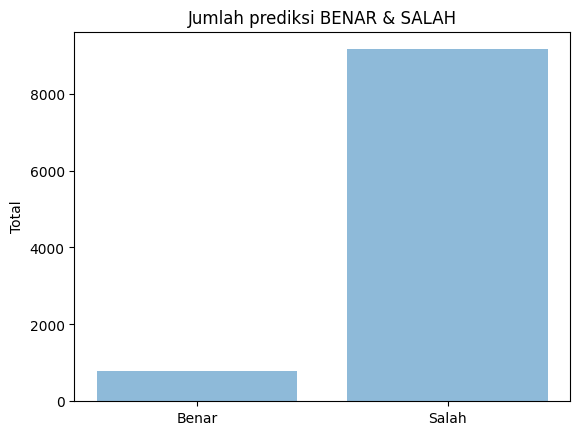

In [29]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Benar', 'Salah')
y_pos = np.arange(len(objects))
performance = [benar, salah]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Total')
plt.title('Jumlah prediksi BENAR & SALAH')

plt.show()

In [30]:
#presentasi benar
p_benar = (benar/(benar+salah))*100
p_salah = (salah/(benar+salah))*100
print('Presentasi benar = {}'.format(p_benar))
print('Presentasi salah = {}'.format(p_salah))

Presentasi benar = 8.02611752887996
Presentasi salah = 91.97388247112004


In [24]:
# image = cv2.imread(CAPTCHA)
# gray, preprocessedImage = preprocessImage(image)
# contours = cv2.findContours(preprocessedImage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = contours[0]
# letter_image_regions = contoursToRectangles(contours)
# letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
# predictions = []
# for letter_bounding_box in letter_image_regions:
#     x, y, w, h = letter_bounding_box
#     letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
#     letter_image = resize_image_to_fit(letter_image, 20, 20)
#     letter_image = np.expand_dims(letter_image, axis=2)
#     letter_image = np.expand_dims(letter_image, axis=0)
#     prediction = model.predict(letter_image)
#     letter = lb.inverse_transform(prediction)[0]
#     predictions.append(letter)

In [ ]:
# predicted_captcha_text = "".join(predictions)
# print("Predicted CAPTCHA text is: {}".format(predicted_captcha_text))
# print("CAPTCHA text is: {}".format(CAPTCHA.split("\\")[-1].split(".")[0]))